# RR Lyrae Classification with Decision Trees
Stephen Portillo (sportill@uw.edu), Astro Hack Week 2020

Based on code by Jake VanderPlas for [Figure 9.12](http://www.astroml.org/book_figures/chapter9/fig_rrlyrae_treevis.html) of _Statistics, Data Mining, and Machine Learning in Astronomy_ (2020) by Ivezić, Connolly, Vanderplas, and Gray

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix
from sklearn.tree import plot_tree

from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

In [2]:
# make the plots look nice
mpl.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')

## What is a Decision Tree?
In a **decision tree**, you start at a **root node** that asks a binary question. The answer to this question then decides which **child node** you go to next. This node may be yet another question, or it can be a **leaf** that denotes a final decision. Paths in a decision tree always ultimately end up on a leaf. The maximum length of a path that can be taken through a tree is its **depth**. As an example, here's a simple decision tree of depth 3 for classifying astronomical objects:

![simple decision tree](decisiontree.png)

In practice, these binary questions will be quantitative and will only involve one **feature** each. We will be using ``scikit-learn`` to [train decision trees](https://scikit-learn.org/stable/modules/tree.html), which uses the [Gini impurity](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation) as the default **loss function**. In the case that there's two classes (labelled - and +), the Gini impurity for a leaf is:

$$L = \frac{N_- \times N_+}{(N_- + N_+)^2}$$

which favours a leaf more the more it contains only one class.

The decision tree is built iteratively: the root node is the binary question that minimizes the total loss function of the two child nodes. Then, each of these child nodes is the binary question that minimizes the total loss of *its* child nodes, until we decide to stop. The greater depth we allow the tree to have, the greater its **capacity** will be.

## Dataset
The ```astroML``` library gives us easy access to a dataset of photometric colours of SDSS standard stars and RR Lyrae stars confirmed by time series observations. Looking at [the documentation](https://www.astroml.org/modules/generated/astroML.datasets.fetch_rrlyrae_combined.html), we see that the four columns of `X` are the colours u-g, g-r, r-i, and i-z, and that `y` is 1 if the star is an RR Lyrae or a 0 if it is not. We have almost 100,000 stars to work with!

In [3]:
# fetch the data and print its dimensions
X, y = fetch_rrlyrae_combined()
features = ['u-g', 'g-r', 'r-i', 'i-z']
labels = ['non-variable', 'RR Lyrae']
print('X.shape', X.shape)
print('y.shape', y.shape)

X.shape (93141, 4)
y.shape (93141,)


We can use this dataset for a **classification** problem: using the photometric colours as **features**, can we predict the **label** of whether the star is an RR Lyrae?

"Classic" machine learning often uses **feature engineering**: transforming the features to make them easier to work with. Notice that the dataset has the 4 photometric colours instead of the five photometric magnitudes, so two stars with different brightnesses but the same colours will have identical feature values. This choice makes sense if we think colours are more important than brightnesses for this classification problem. Indeed, two stars that are identical but are just at different distances will have different brightnesses but the same colours. Still, RR Lyrae could have a different brightness distribution than non-variable stars, which would be useful for classification, but is not captured in our dataset.

It's always a good idea to do some exploratory data visualization to see what your data looks like. If there are only a few features, a corner plot can be a useful tool. [corner.py](https://corner.readthedocs.io/) makes nice corner plots, but doesn't allow you to colour points based on their labels, while [Seaborn](https://seaborn.pydata.org/generated/seaborn.pairplot.html) does. Instead of adding another dependency to this notebook, I decided to make my own corner plot with `matplotlib`.

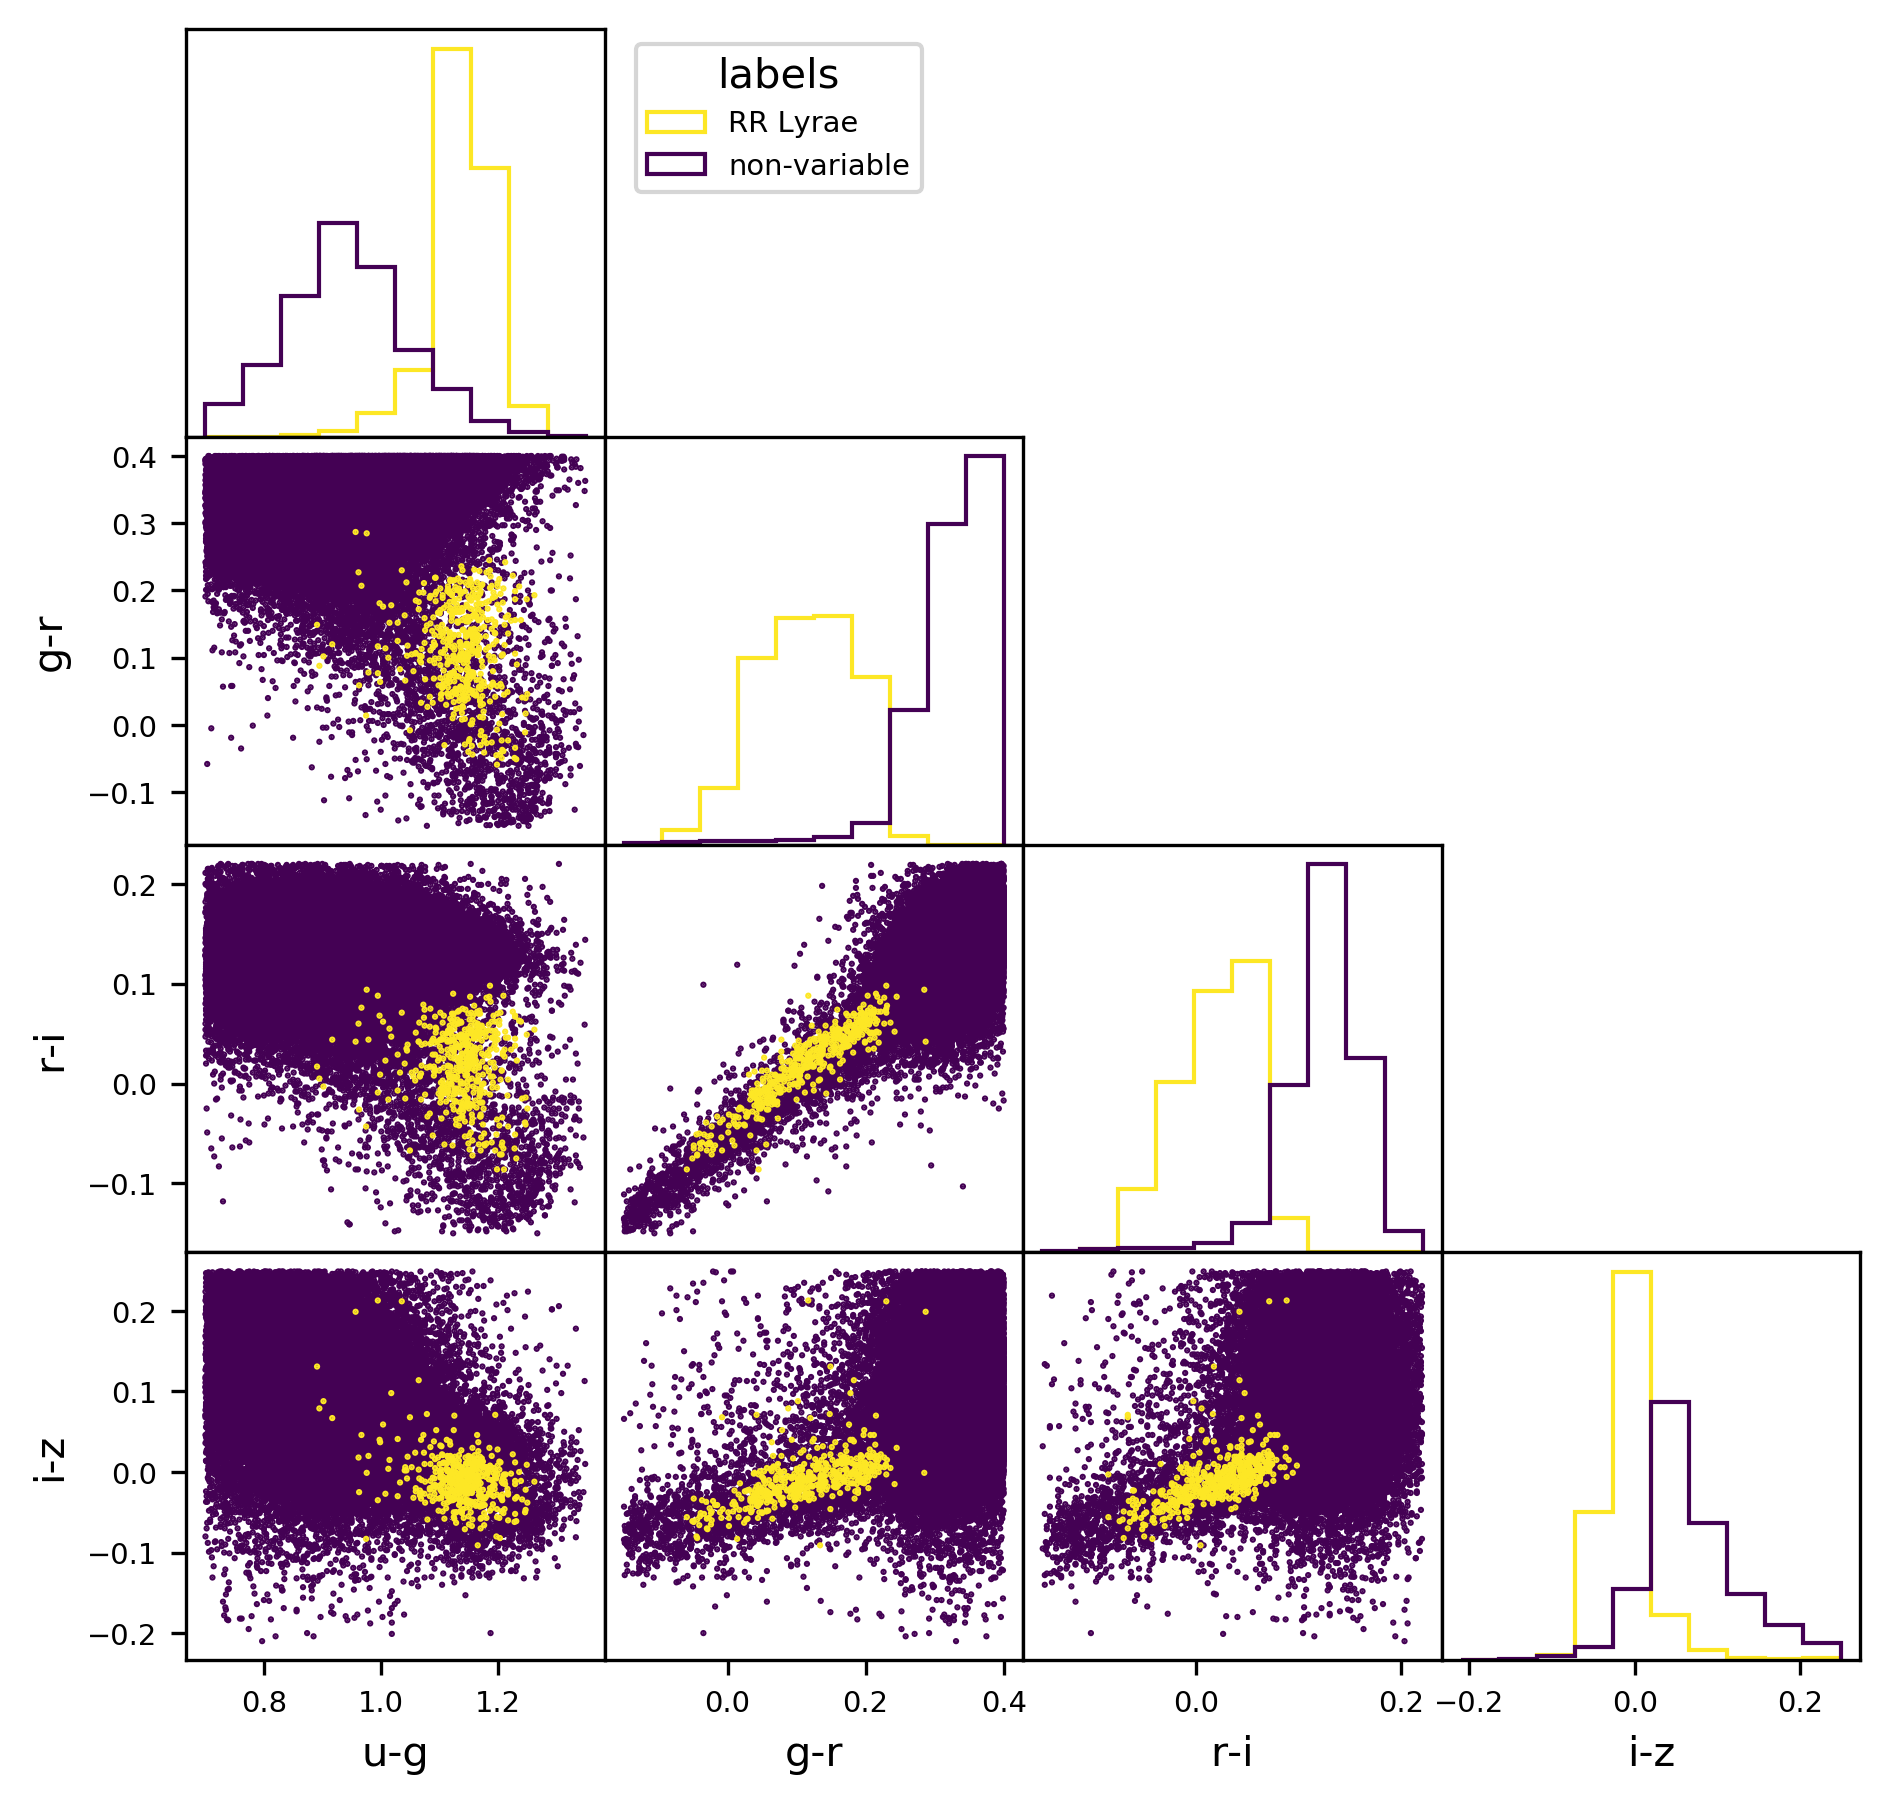

In [4]:
# make a corner plot
from matplotlib import cm
cmap = cm.get_cmap('viridis')

fig = plt.figure(figsize=(7.2,7.2))
fig.subplots_adjust(hspace=0, wspace=0)
# loop through every possible pair of features
for i in range(4):
    for j in range(4):
        # only make subplots in the lower diagonal
        if i <= j:
            plt.subplot(4,4,i+j*4+1)
            # if this subplot is on the left side (but not the top), make a y label
            if i == 0 and j != 0:
                plt.ylabel(features[j])
            # if this subplot is on the bottom, make an x label
            if j == 3:
                plt.xlabel(features[i])
            # remove ticks on interior plots
            if i != 0:
                plt.yticks([])
            if j != 3:
                plt.xticks([])
            # scatter plots in off diagonals
            if i < j:
                plt.scatter(X[:,i], X[:,j], s=1, marker='.', c=y, cmap=cmap)
            # normalized histograms on diagonals, with same colour map as scatter plots
            if i == j:
                plt.hist(np.array([X[y == 0, i], X[y == 1, i]], dtype='object'), density=True, histtype='step',\
                         label=labels, color=[cmap(0.), cmap(1.)])
                plt.yticks([]) # don't want counts in the y-axis
                # add a legend
                if i == 0:
                    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', title='labels')
plt.show()

We see that the RR Lyrae occupy a somewhat distinct part of colour space, so trying to find them based on colour seems reasonable. You'll notice that there are hard boundaries in colour space: we've already done some colour cuts to select stars that have colours similar to RR Lyrae. One thing to note is that there are variable stars that are not RR Lyrae, whereas our dataset only has non-variable stars and RR Lyrae. Even if our model does well on this dataset, we should be careful using it on other data that may contain variable stars that are not RR Lyrae.

## Importance of the Validation Set

We will split our dataset into a **training set** (75%) and **validation set** (25%). If we are interested in comparing to other people's work, we should also hold out a separate **test set**.

In [5]:
# split our data into training and validation sets
# setting random_state makes this split deterministic
(X_train, X_valid), (y_train, y_valid) = split_samples(X, y, [0.75, 0.25], random_state=0)

Why do we need a validation set? Let's [train a decision tree](https://scikit-learn.org/stable/modules/tree.html) with a lot of capacity:

In [6]:
%%time
# train a decision tree with a depth up to 15
tree = DecisionTreeClassifier(random_state=0, max_depth=20)
tree.fit(X_train, y_train)

CPU times: user 97.4 ms, sys: 92 µs, total: 97.5 ms
Wall time: 96.7 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Even though the decision tree minimizes the loss function (the Gini impurity), we're more interested in the precision and recall:
- **recall**: What fraction of the RR Lyrae in the dataset does our classifier find?
- **precision**: What fraction of the objects our classifier identifies as RR Lyrae are actually RR Lyrae?

Astronomers may say **completeness** instead of recall, and talk about the **contamination**, which is 1 minus the precision. 

In [7]:
print('Recall %0.3f' % recall_score(y_train, tree.predict(X_train)))
print('Precision %0.3f' % precision_score(y_train, tree.predict(X_train)))

Recall 1.000
Precision 1.000


Those numbers look great! But we're evaluating the decision tree using the same data we used to train it. What if we evaluate the tree using the validation set?

In [8]:
print('Recall %0.3f' % recall_score(y_valid, tree.predict(X_valid)))
print('Precision %0.3f' % precision_score(y_valid, tree.predict(X_valid)))

Recall 0.467
Precision 0.557


Hmm, those numbers aren't nearly as impressive. It appears our tree is **overfitting**: it perfectly predicts the training data, but does not do well on data it hasn't seen before.

## Looking at a Decision Tree
Let's train another tree with a depth of 4 and look at it in more detail:

In [9]:
%%time
# train a decision tree with a depth up to 4
tree = DecisionTreeClassifier(random_state=0, max_depth=4)
tree.fit(X_train, y_train)

CPU times: user 60.6 ms, sys: 991 µs, total: 61.6 ms
Wall time: 60.8 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

There's a convenience function to [plot the trained tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html): left is False and right is True. Only one leaf in the tree has a majority of RR Lyrae and thus predicts the star to be an RR Lyrae. (You'll need to zoom in to read the tree.)

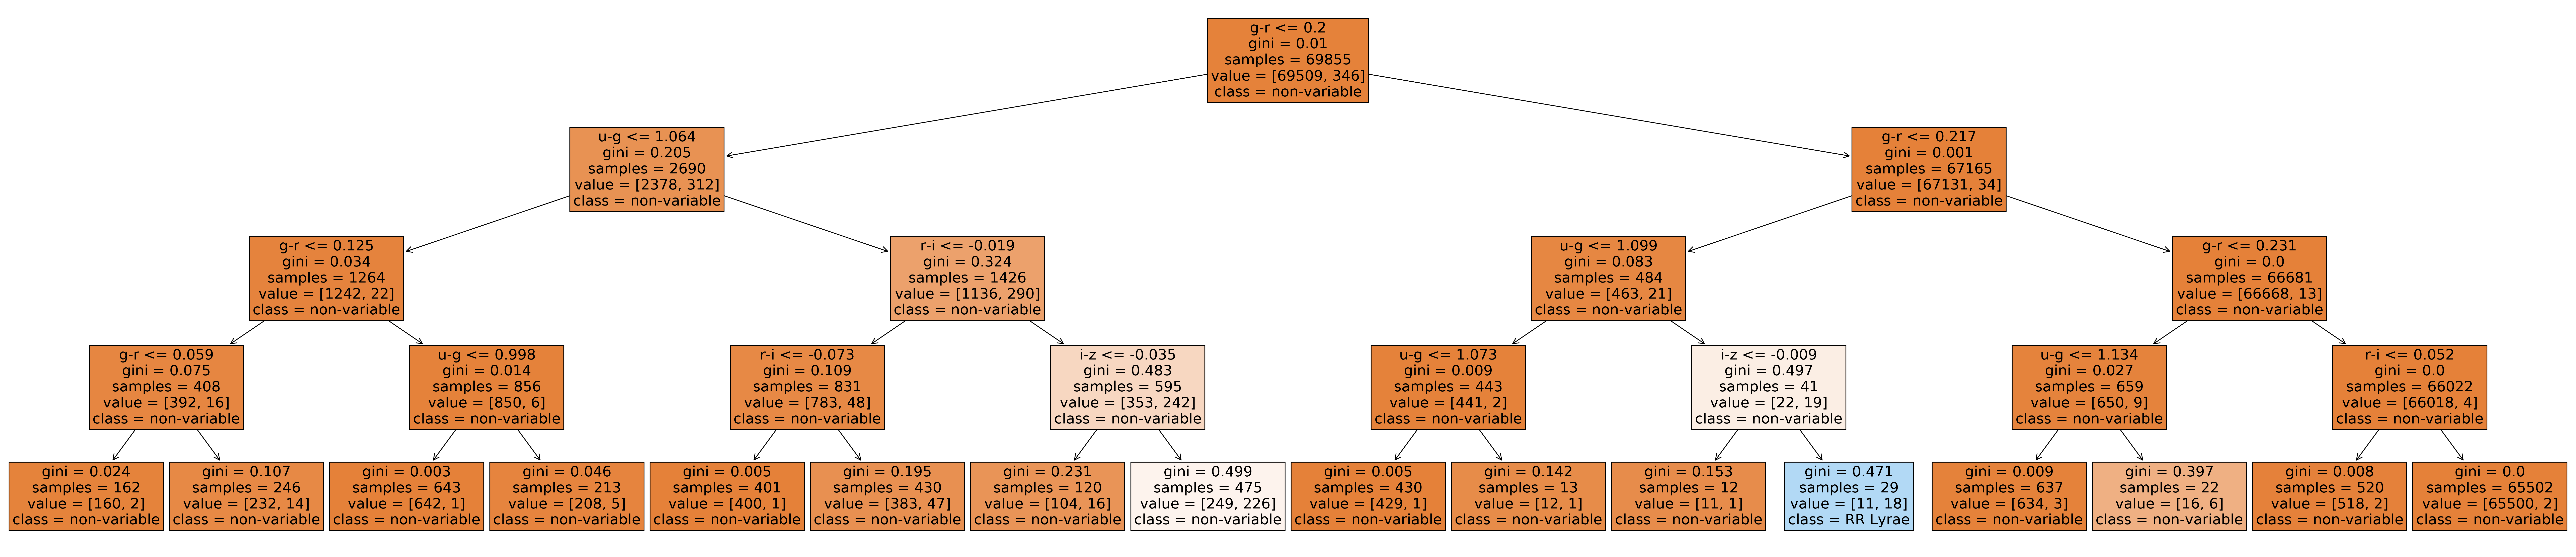

In [10]:
# plot this decision tree
plt.figure(figsize=(55,12))
plot_tree(tree, feature_names=features, class_names=labels, fontsize='xx-large', filled=True)
plt.show()

We can understand the first two levels of the tree by looking at a scatter plot of u-g and g-r:

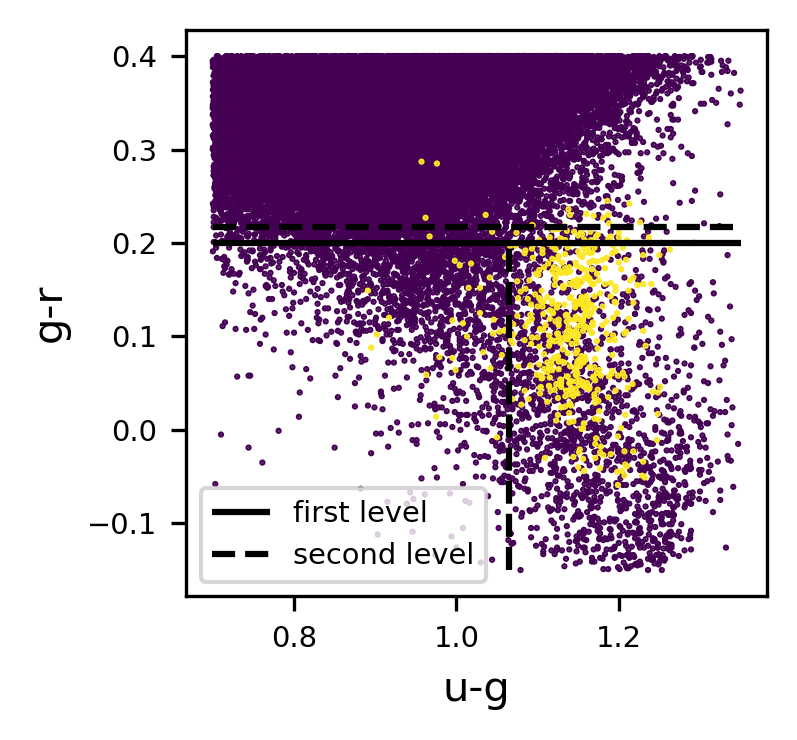

In [11]:
fig = plt.figure(figsize=(2.5,2.5))

plt.scatter(X[:,0], X[:,1], s=1, marker='.', c=y, cmap=cmap)
plt.xlabel(features[0])
plt.ylabel(features[1])

# This code is specific to the trained tree, and will not display the correct lines in general
plt.hlines(tree.tree_.threshold[0], xmin=np.min(X[:,0]), xmax=np.max(X[:,0]), label='first level')
plt.vlines(tree.tree_.threshold[1], ymin=np.min(X[:,1]), ymax=tree.tree_.threshold[0], ls='--', label='second level')
plt.hlines(tree.tree_.threshold[16], xmin=np.min(X[:,0]), xmax=np.max(X[:,0]), ls='--')

plt.legend()
plt.show()

The most useful first question to separate out the RR Lyrae is a cut at g-r = 0.2. Below this line, most of the RR Lyrae can be found to the right of u-g = 1.064. Above the line, the tree decided to ask whether g-r was below g-r = 0.217.

Instead of just looking at the precision and recall, we are also interested in the **confusion matrix**. Each star is put into one of the cells of the confusion matrix based on its true label (from the dataset) and its predicted label (from the decision tree). `scikit-learn` again has a [convenience function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) that we will use to plot the confusion matrix for the validation set.

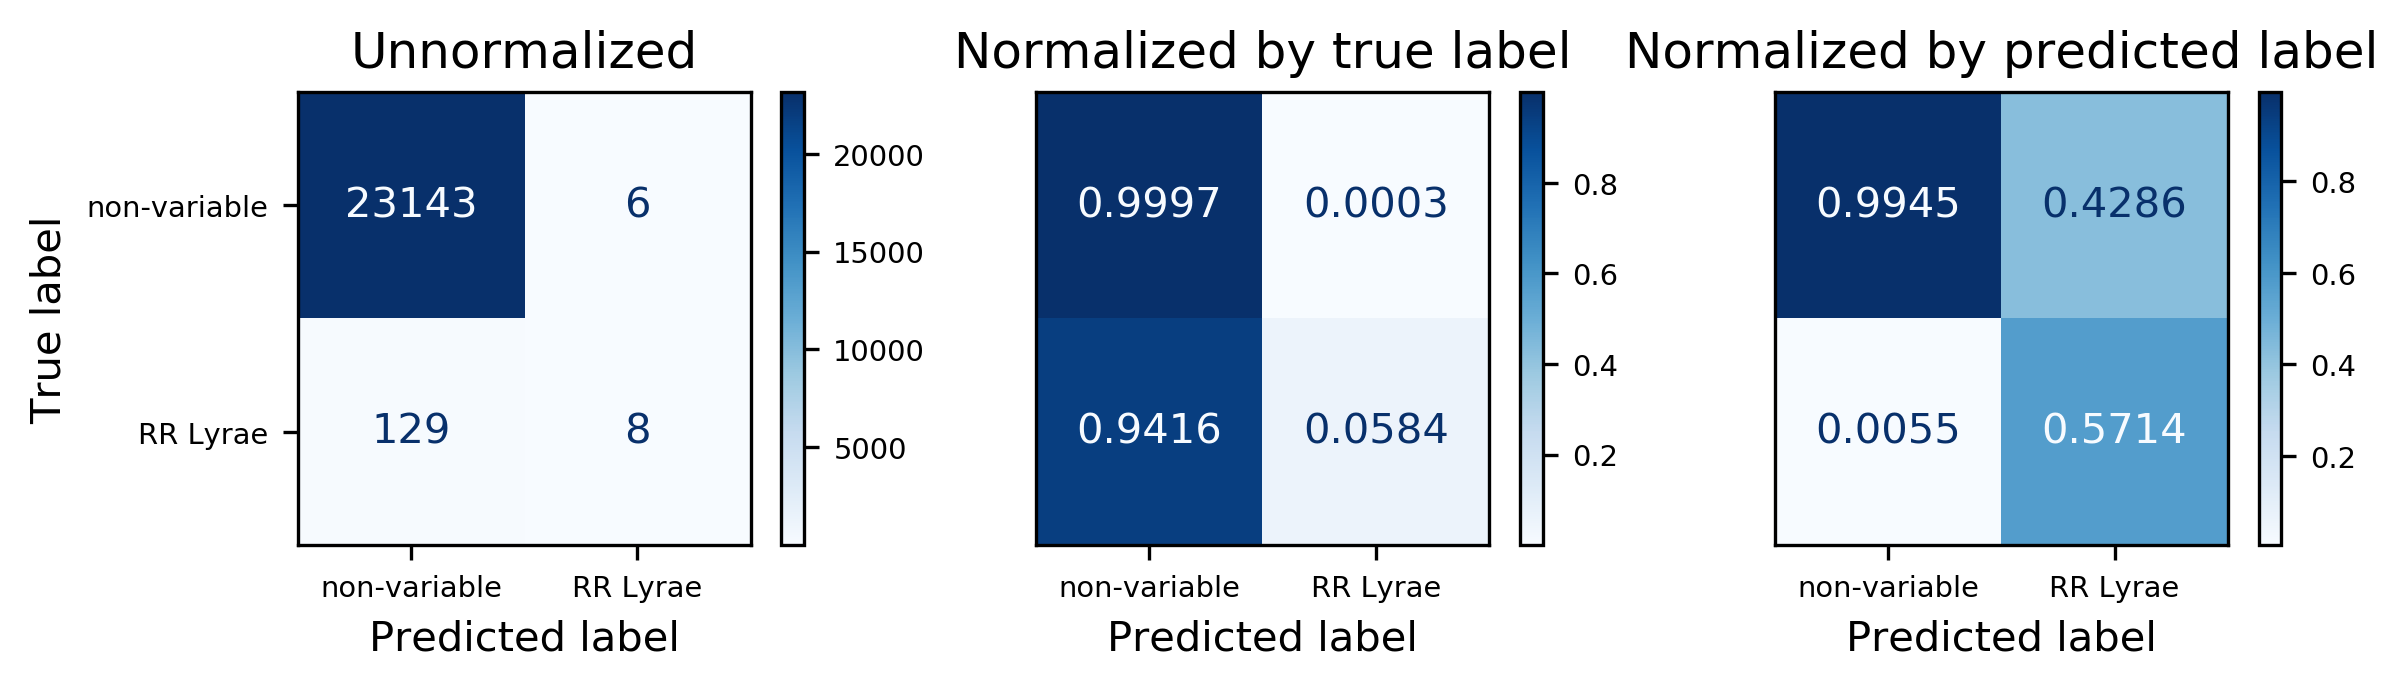

In [12]:
# plot the confusion matrix
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,2))

# unnormalized version
disp = plot_confusion_matrix(tree, X_valid, y_valid, display_labels=labels, \
                      values_format='d', ax=ax[0], cmap='Blues')
disp.ax_.set_title('Unnormalized')

# normalized by true label
disp = plot_confusion_matrix(tree, X_valid, y_valid, display_labels=labels, \
                      normalize='true', ax=ax[1], values_format='.4f', cmap='Blues')
disp.ax_.set_title('Normalized by true label')
disp.ax_.set_ylabel('')
disp.ax_.set_yticks([])

# normalized by predicted label
disp = plot_confusion_matrix(tree, X_valid, y_valid, display_labels=labels, \
                      normalize='pred', values_format='.4f', ax=ax[2], cmap='Blues')
disp.ax_.set_title('Normalized by predicted label')
disp.ax_.set_ylabel('')
disp.ax_.set_yticks([])
plt.show()

The unnormalized confusion matrix is useful because it shows how many data points landed in each cell, but it can be harder to interpret when one class is rare, like the RR Lyrae in our case.

Instead, the confusion matrix is often normalized by the true label, meaning that each row adds up to 1, so we can see what fraction of stars with each true label ended up in each cell. We see that only 0.03% of the true non-variable stars were misclassified as RR Lyrae, while only 6% of the true RR Lyrae were identified as RR Lyrae. This tree has 6% recall for RR Lyrae.

Less commonly, the confusion matrix can by normalized by the predicted label, meaning that each column adds up to 1, so we can see what fraction of stars with each _predicted_ label ended up in each cell. We can see that even though only a tiny fraction of the true non-variable stars were misclassified, they comprise a large fraction of the predicted RR Lyrae - 43%! That is, this tree has 43% contamination (or 57% precision) for RR Lyrae. 

## Hyperparameter Tuning

`scikit-learn` has built in functions to do [hyperparameter tuning](https://scikit-learn.org/stable/model_selection.html) based on a validation set, but we'll write out the code so we can see how it works. The **parameters** that we trained are which features to split on and what thresholds to use at each node in the tree. The most important **hyperparameter** is the maximum tree depth - how big to make the tree in the first place.

Again, while the loss function is the Gini impurity, we're more interested in the precision and recall. So let's train trees with a variety of depths on the same training set, and see how they do on the validation set:

In [13]:
depth  = range(4,11) # set of different tree depths we'll use

# make arrays to hold the precision and recall
recall_train = np.zeros(len(depth))
precis_train = np.zeros(len(depth))

recall_valid = np.zeros(len(depth))
precis_valid = np.zeros(len(depth))

for i, d in enumerate(depth):
    tree = DecisionTreeClassifier(random_state=0, max_depth=d)
    tree.fit(X_train, y_train)

    # get predictions for TRAINING SET
    y_pred_train = tree.predict(X_train)
    # calculate precision and recall
    recall_train[i] = recall_score(y_train, y_pred_train)
    precis_train[i] = precision_score(y_train, y_pred_train)
    
    # get predictions for VALIDATION SET
    y_pred_valid = tree.predict(X_valid)
    # calculate precision and recall
    recall_valid[i] = recall_score(y_valid, y_pred_valid)
    precis_valid[i] = precision_score(y_valid, y_pred_valid)

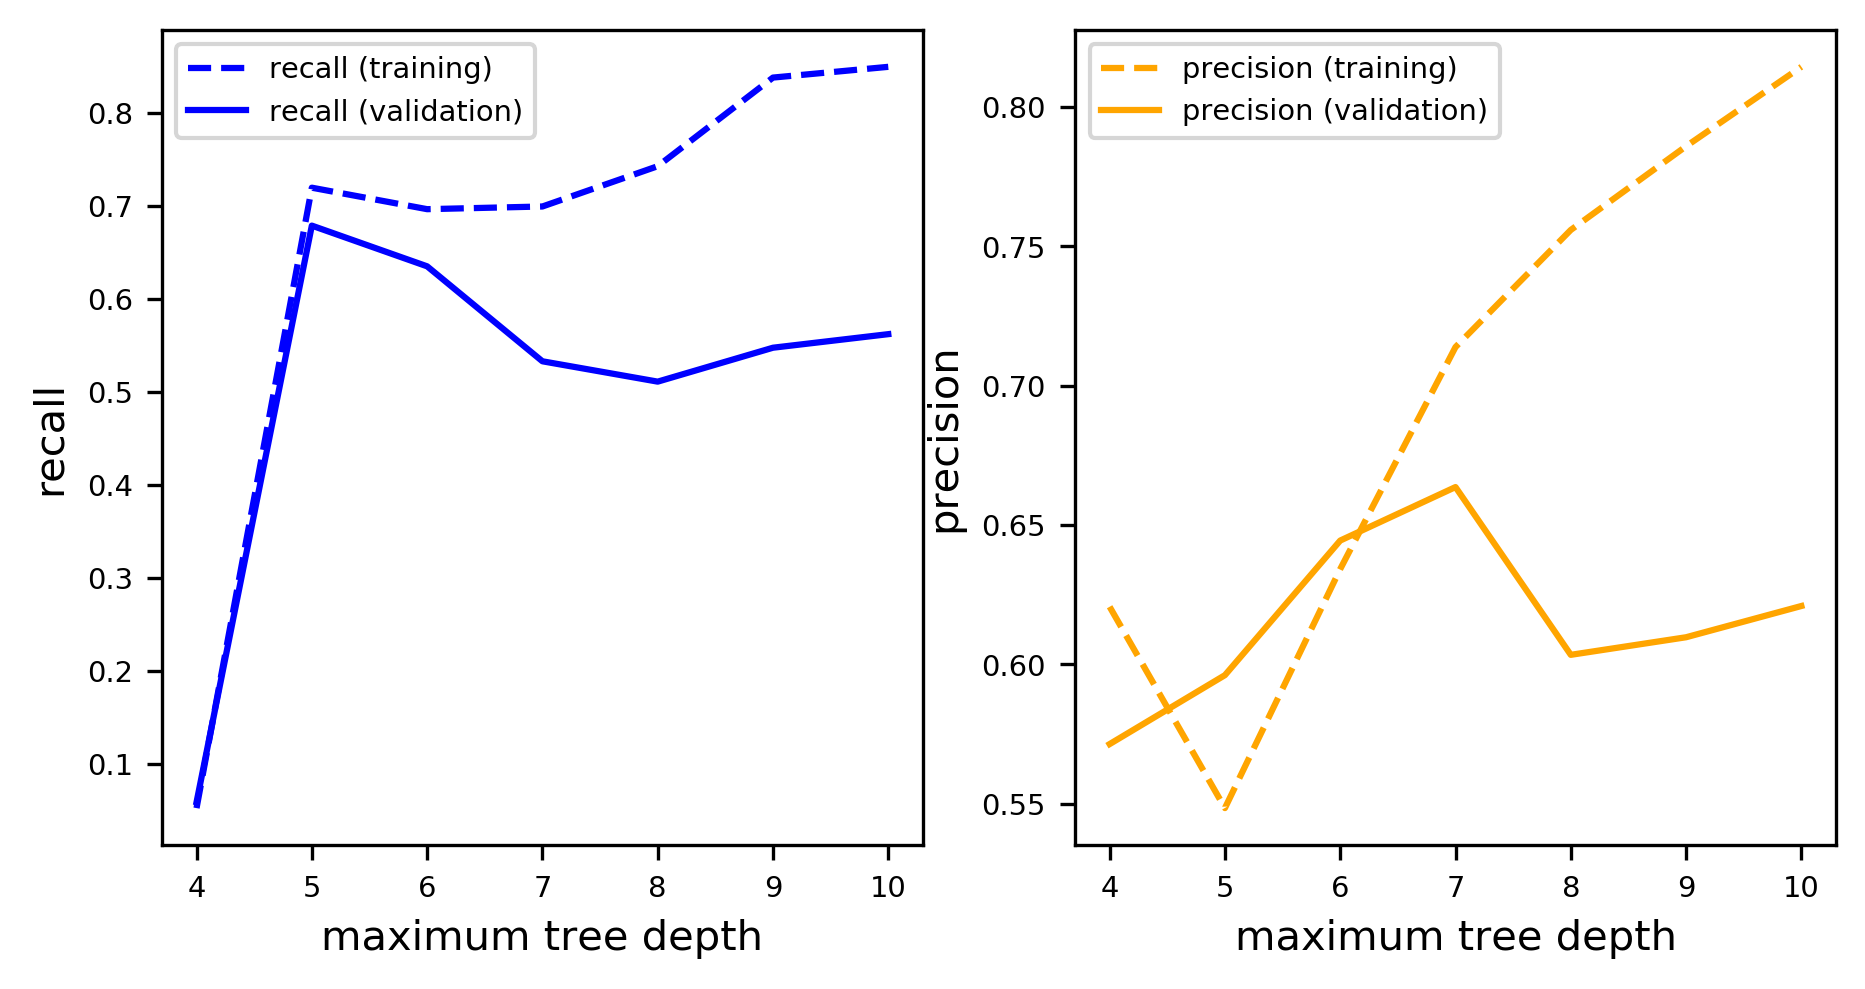

In [14]:
plt.figure(figsize=(7.2,3.6))
plt.subplot(1,2,1)
plt.plot(depth, recall_train, c='b', ls='--', label='recall (training)')
plt.plot(depth, recall_valid, c='b', label='recall (validation)')
plt.ylabel('recall')
plt.xlabel('maximum tree depth')
plt.legend()
plt.subplot(1,2,2)
plt.plot(depth, precis_train, c='orange', ls='--', label='precision (training)')
plt.plot(depth, precis_valid, c='orange', label='precision (validation)')
plt.ylabel('precision')
plt.xlabel('maximum tree depth')
plt.legend()
plt.show()

Note how the precision and recall are usually (but not always) better on the training set than the validation set. With a tree depth of 4, the tree **underfits**: performance is poor on both the training and validation sets. At a tree depth of 10, the tree is clearly **overfitting**: it does much better on the training set than on the validation set.

If we wanted to maximize recall, we would choose a tree depth of 5, while if we wanted to maximize precision, we would choose a tree depth of 7. Depending on our goals, we might want to maximize some combination of precision and recall, with weights depending on how problematic false positives are compared to false negatives.

## More Hyperparameters?
Another hyperparameter we can set is our choice of loss function for training the decision tree. The `scikit-learn` default is the Gini impurity, but an alternate choice is the **information gain**, which can be set by adding the keyword `criterion='entropy'` to `DecisionTreeClassifier()`. Try repeating the hyperparameter search using tree depths from 4 to 10 and using the information gain instead of the Gini impurity. Use the same training and validation sets so that the results can be directly compared. Which loss function gives better precision and recall?

## Random Forests

A generalization of decision trees, **random forests**, are often used in state-of-the-art classifiers. For example, [Jayasinghe et al. (2019)](https://academic.oup.com/mnras/article-abstract/486/2/1907/5420510) use random forests to classify 412 000 variable stars observed by ASAS-SN. Random forests make an ensemble of decision trees using two techniques to introduce variation between the trees:

- **bagging (bootstrap aggregating)**: each tree in the ensemble is trained on a different subset of the data
- **feature bagging**: whenever a node is split, restrict the features that can be used in the binary question to a random subset of the features

The ensemble of trees then vote on the classification, with majority rule. The number of trees that vote for a classification can be used as a measure of how confident the classification is. Random forests are less prone to overfitting than single decision trees.

![random forest](randomforest.png)


`scikit-learn` also makes it easy to try out random forest classifiers! Check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for `RandomForestClassifier` and compare it to our decision trees.